<a href="https://colab.research.google.com/github/viniventur/TS-ICMS-Previsao/blob/main/TS_ICMS_Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando Séries Temporais na Previsão de **Arrecadação de ICMS para Alagoas** no período de **2008 a 2021**
# Modelos usados: Suavização Exponencial, Holt-Winters e SARIMA (incompleto)
## Por: Vinícius Ventura


## Instalação dos pacotes iniciais

In [ ]:
# Pacotes de gerenciamento do sistema operacional, como manipulação de arquivos e diretórios, gerenciamento de processos, obtenção de informações do sistema, etc.
import os
from google.colab import drive
drive.mount('/content/drive')

# Pacotes para manipulação e tratamento de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Pacotes para análise gráfica
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Pacotes para análise econométrica
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ES e Holt-Winters
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

Mounted at /content/drive


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/ECONOMETRIA/Dados-AB2/AJUSTADO-IMPOSTOS 2008-2023 ICMS-ITCD-IPVA-IRRF.xlsx")
df

,ANO,MES,ICMS,IPVA,ITCD,IRRF
0,1999,1,1.435041e+08,658956.65,21163.97,2.503588e+06
1,1999,2,1.339496e+08,1032605.36,13089.30,2.704361e+06
2,1999,3,1.263094e+08,2489990.52,26279.08,2.506033e+06
3,1999,4,1.245758e+08,1851256.22,42705.30,2.912700e+06
4,1999,5,1.288502e+08,1905139.44,27892.99,2.924607e+06
...,...,...,...,...,...,...
286,2022,11,5.007574e+08,19444161.37,3686703.83,6.999604e+07
287,2022,12,5.177060e+08,16460877.34,3784183.93,1.539830e+08
288,2023,1,5.190866e+08,87731781.40,3490818.53,4.479230e+07
289,2023,2,4.914509e+08,38299782.86,2960060.37,1.135633e+08


In [ ]:
df['Total'] = df.ICMS + df.IPVA + df.IRRF + df.ITCD
df

,ANO,MES,ICMS,IPVA,ITCD,IRRF,Total
0,1999,1,1.435041e+08,658956.65,21163.97,2.503588e+06,1.466878e+08
1,1999,2,1.339496e+08,1032605.36,13089.30,2.704361e+06,1.376996e+08
2,1999,3,1.263094e+08,2489990.52,26279.08,2.506033e+06,1.313317e+08
3,1999,4,1.245758e+08,1851256.22,42705.30,2.912700e+06,1.293825e+08
4,1999,5,1.288502e+08,1905139.44,27892.99,2.924607e+06,1.337078e+08
...,...,...,...,...,...,...,...
286,2022,11,5.007574e+08,19444161.37,3686703.83,6.999604e+07,5.938843e+08
287,2022,12,5.177060e+08,16460877.34,3784183.93,1.539830e+08,6.919340e+08
288,2023,1,5.190866e+08,87731781.40,3490818.53,4.479230e+07,6.551015e+08
289,2023,2,4.914509e+08,38299782.86,2960060.37,1.135633e+08,6.462741e+08


In [ ]:
# Limpando a base

df.dropna(inplace=True)
df['Data'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str))
df = df.set_index("Data")
df = df.drop(['MES', 'ANO'], axis=1)
# Filtrando de 2008 a 2021
df22 = df
df = df.loc[(df.index >= '2008-01-01') & (df.index <= '2021-12-01')]
df

,ICMS,IPVA,ITCD,IRRF,Total
Data,,,,,
2008-01-01,1.435041e+08,247577.51,254215.72,4.840761e+05,1.444900e+08
2008-02-01,1.339496e+08,434807.82,102325.82,8.355140e+06,1.428418e+08
2008-03-01,1.263094e+08,977710.59,200864.10,1.906390e+07,1.465519e+08
2008-04-01,1.245758e+08,2039601.25,149966.47,1.104372e+07,1.378091e+08
2008-05-01,1.288502e+08,5231902.65,225509.28,1.500067e+07,1.493082e+08
...,...,...,...,...,...
2021-08-01,4.654184e+08,34028454.42,4602640.98,5.461557e+07,5.586650e+08
2021-09-01,4.484894e+08,24834804.30,3012063.52,5.197801e+07,5.283142e+08
2021-10-01,4.884993e+08,19528953.50,2405155.18,4.057653e+07,5.510100e+08


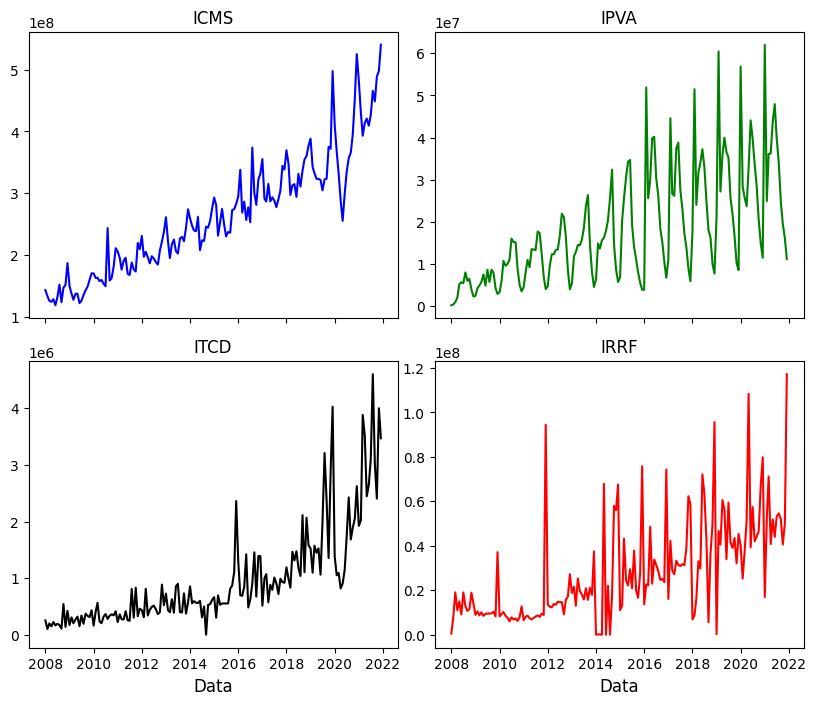

In [ ]:
# visualização
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(10, 8))
# ICMS
sns.lineplot(x=df.index,
            y=df.ICMS,
             color='blue',
            ax=ax1)
# IPVA
sns.lineplot(x=df.index,
            y=df.IPVA,
             color='green',
            ax=ax2)
# ITCD
sns.lineplot(x=df.index,
            y=df.ITCD,
             color='black',
            ax=ax3)
# IRRF
sns.lineplot(x=df.index,
            y=df.IRRF,
             color='red',
            ax=ax4)
# Ajustar os títulos dos eixos e o espaçamento
plt.subplots_adjust(hspace=0.15, wspace=0.1)
# Iterando as colunas nos títulos
for i, ax in zip(df.iloc[:, :4].columns, (ax1, ax2, ax3, ax4)):
    ax.set_title(i, fontsize=12)
# looping para setar o tamanho do x e tirar os y labels 
for i in (ax1,ax2,ax3,ax4):
  i.set_xlabel('Data', fontsize=12)
  i.set_ylabel('')
plt.show()

# Início das análises
## Análise para o ICMS - Imposto sobre Operações relativas à Circulação de Mercadorias e Prestação de Serviços de Transporte Interestadual e Intermunicipal e de Comunicação

# Reprodução da parte 2 - Análise da Série Não Deflacionada

## Análise Descritiva

In [ ]:
icms = pd.DataFrame(df.ICMS)
icms

,ICMS
Data,
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2021-08-01,4.654184e+08
2021-09-01,4.484894e+08
2021-10-01,4.884993e+08


In [ ]:
icms.describe()

,ICMS
count,1.680000e+02
mean,2.632525e+08
std,9.501042e+07
min,1.191132e+08
25%,1.885501e+08
50%,2.530290e+08
75%,3.232738e+08
max,5.400592e+08


Realizar uma análise descritiva é importante para que seja possível identificar algumas informações como: média, desvio-padrão, mínimo e máximo. Com a análise feita acima podemos identificar tais pontos para nossa série temporal:
N° de observações = 168
Média = 263.252.500
Desvio-padrão (dispersão)= 95.010.420
Mínimo = 119.113.200
Máximo= 540.059.200

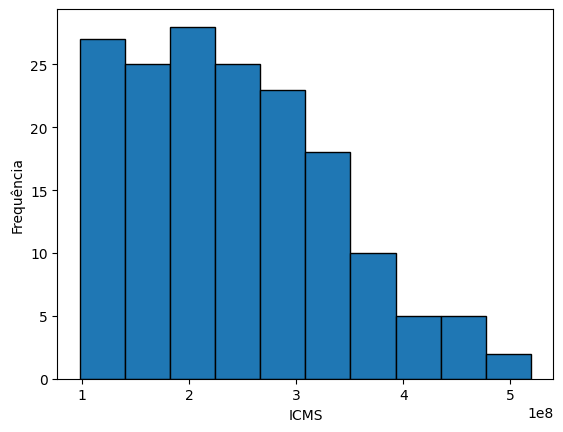

In [ ]:
plt.hist(icms, align='left', histtype='bar', edgecolor='black')
plt.title("")  # Título do histograma
plt.xlabel("ICMS")  # Rótulo do eixo x
plt.ylabel("Frequência")  # Rótulo do eixo y

plt.show()  # Exibe o histograma

## Análise Econométrica e Previsões

### Métodos Baseados na **Média**

#### 1. Método da Média Simples

$$\bar{y} = \frac{\sum y\small{t}}{n}$$

Onde $n$ é o número de pontos observados da série e $y_t$ representa o valor de cada um. Os valores previstos para $t > n$, $\hat{y}_t$, são todos iguais a $\bar{y}_t$.

In [ ]:
# Fazendo a média simples para cada valor
icms['Media'] = icms['ICMS'].expanding().mean()
icms

,ICMS,Media
Data,,
2008-01-01,1.435041e+08,1.435041e+08
2008-02-01,1.339496e+08,1.387268e+08
2008-03-01,1.263094e+08,1.345877e+08
2008-04-01,1.245758e+08,1.320847e+08
2008-05-01,1.288502e+08,1.314378e+08
...,...,...
2021-08-01,4.654184e+08,2.576320e+08
2021-09-01,4.484894e+08,2.587887e+08
2021-10-01,4.884993e+08,2.601725e+08


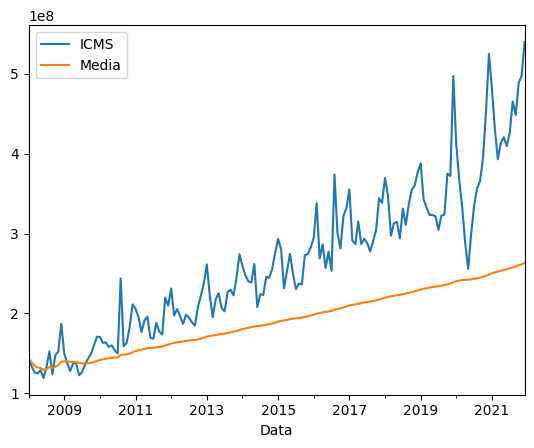

In [ ]:
icms.ICMS.plot()
icms['Media'].plot()
plt.legend()
plt.show() 

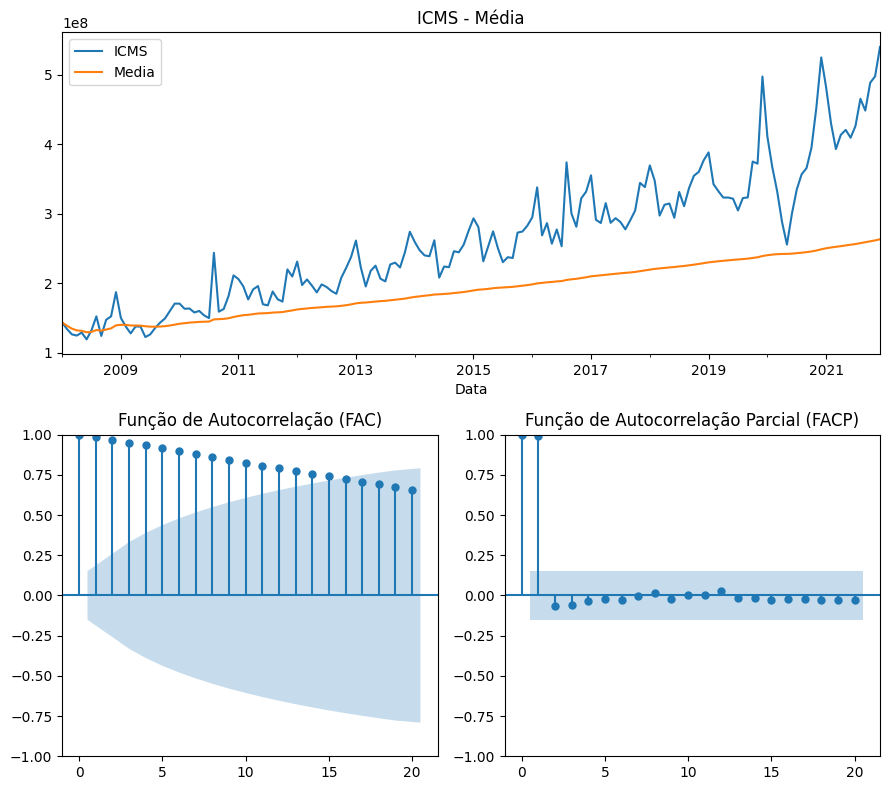

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(2, 2)
# ax1
ax1 = plt.subplot(gs[0, :])
icms.ICMS.plot(ax=ax1)
icms['Media'].plot(ax=ax1)
plt.legend() 
ax1.set_title('ICMS - Média')

# FAC
ax2 = plt.subplot(gs[1, 0])
plot_acf(icms['Media'], lags=20, ax=ax2)
ax2.set_title('Função de Autocorrelação (FAC)')

# FACP
ax3 = plt.subplot(gs[1, 1])
plot_pacf(icms['Media'], lags=20, ax=ax3)
ax3.set_title('Função de Autocorrelação Parcial (FACP)')

plt.tight_layout()
plt.show()

In [ ]:
icmsresid = icms.ICMS.values - icms.Media.values
icmsresid

array([ 0.00000000e+00, -4.77727285e+06, -8.27829740e+06, -7.50890041e+06,
       -2.58764803e+06, -1.02705257e+07,  2.39159569e+06,  1.96767030e+07,
       -7.58421896e+06,  1.42095469e+07,  1.72374033e+07,  4.78258683e+07,
        9.85885804e+06, -2.32600107e+06, -1.13487423e+07, -1.44700372e+06,
       -1.33607483e+06, -1.55571251e+07, -1.11136724e+07, -1.77388760e+06,
        5.58091576e+06,  1.10460924e+07,  2.08131822e+07,  3.02378612e+07,
        2.89650839e+07,  2.07458314e+07,  2.03788434e+07,  1.41375808e+07,
        1.57167254e+07,  9.02748183e+06,  4.99700580e+06,  9.58823361e+07,
        1.07946098e+07,  1.42264973e+07,  3.22497209e+07,  5.99408513e+07,
        5.31977066e+07,  4.15163288e+07,  2.21027112e+07,  3.56888440e+07,
        3.94706149e+07,  1.29895404e+07,  1.10871959e+07,  3.04102191e+07,
        1.88573628e+07,  1.50488861e+07,  6.00734062e+07,  4.88382426e+07,
        6.88976003e+07,  3.44301244e+07,  4.16274092e+07,  3.22277948e+07,
        2.19726402e+07,  

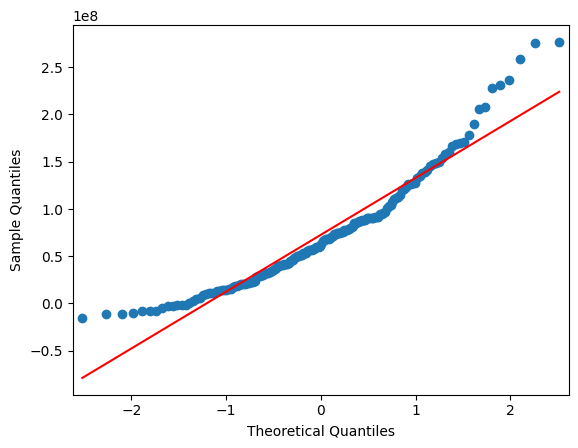

In [ ]:
sm.qqplot(icmsresid, line='s');

In [ ]:
# Teste de Jarque-Bera para normalidade dos resíduos
jb_value, p_value, skew, kurtosis = sm.stats.jarque_bera(icmsresid)
jb = np.array([jb_value, p_value, skew, kurtosis])
jbresult = pd.DataFrame({"Estatística de Jarque-Bera": jb[0], "Valor p": jb[1]}, index=[0])
jbresult

,Estatística de Jarque-Bera,Valor p
0,42.966257,4.677306e-10


**Rejeito a hipótese nula de normalidade dos resíduos**

In [ ]:
# Teste Box-Pierce de independência dos resíduos
# H0: Não há autocorrelação nos resíduos
sm.stats.acorr_ljungbox(icmsresid, boxpierce=True, lags=[12], return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,753.355061,1.649993e-153,718.102142,5.871840e-146


**Rejeito a hipótese nula de não autocorrelação**

#### 2. Método da Média Movel

$$\hat{y}_{n+1} = \frac{1}{m} \sum_{i=n-m+1}^t y_i$$

Neste método, cada ponto da nova série modelada é calculado como sendo a média
dos valores das $m$ observações anteriores. Todas as observações são ponderadas pelo mesmo
valor $(\frac{1}{m})$.

O número de pontos conhecidos da série é representado pelo parâmetro $n$, enquanto $m$ representa a ordem do modelo de média móvel.

Método das Médias Móveis do artigo de referência foi feito com $m = 3, 5, 7$ e $9$.


In [ ]:
ms = [3,5,7,9]
for i in ms:
  icms['MM'+ str(i)] = icms.ICMS.rolling(i).mean()
icms

,ICMS,Media,MM3,MM5,MM7,MM9
Data,,,,,,
2008-01-01,1.435041e+08,1.435041e+08,NaN,NaN,NaN,NaN
2008-02-01,1.339496e+08,1.387268e+08,NaN,NaN,NaN,NaN
2008-03-01,1.263094e+08,1.345877e+08,1.345877e+08,NaN,NaN,NaN
2008-04-01,1.245758e+08,1.320847e+08,1.282783e+08,NaN,NaN,NaN
2008-05-01,1.288502e+08,1.314378e+08,1.265785e+08,1.314378e+08,NaN,NaN
...,...,...,...,...,...,...
2021-08-01,4.654184e+08,2.576320e+08,4.337554e+08,4.271010e+08,4.226514e+08,4.405991e+08
2021-09-01,4.484894e+08,2.587887e+08,4.468008e+08,4.340840e+08,4.252941e+08,4.321007e+08
2021-10-01,4.884993e+08,2.601725e+08,4.674690e+08,4.476510e+08,4.389276e+08,4.328388e+08


In [ ]:
icmsmm = icms.dropna()
icmsmm

,ICMS,Media,MM3,MM5,MM7,MM9
Data,,,,,,
2008-09-01,1.240610e+08,1.316452e+08,1.361683e+08,1.312936e+08,1.296219e+08,1.316452e+08
2008-10-01,1.474336e+08,1.332241e+08,1.412549e+08,1.350103e+08,1.326397e+08,1.320819e+08
2008-11-01,1.521852e+08,1.349478e+08,1.412266e+08,1.416247e+08,1.365839e+08,1.341080e+08
2008-12-01,1.871215e+08,1.392956e+08,1.622468e+08,1.526143e+08,1.449083e+08,1.408649e+08
2009-01-01,1.499761e+08,1.401172e+08,1.630943e+08,1.521555e+08,1.493173e+08,1.436872e+08
...,...,...,...,...,...,...
2021-08-01,4.654184e+08,2.576320e+08,4.337554e+08,4.271010e+08,4.226514e+08,4.405991e+08
2021-09-01,4.484894e+08,2.587887e+08,4.468008e+08,4.340840e+08,4.252941e+08,4.321007e+08
2021-10-01,4.884993e+08,2.601725e+08,4.674690e+08,4.476510e+08,4.389276e+08,4.328388e+08


<Axes: xlabel='Data'>

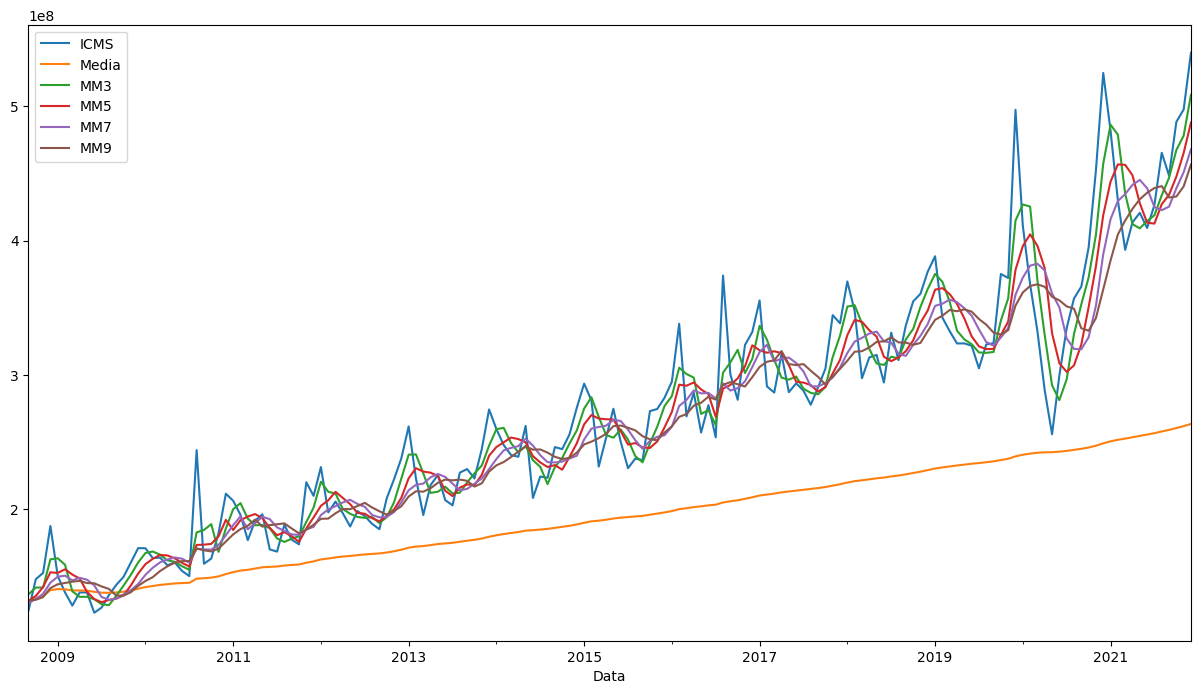

In [ ]:
icmsmm.plot(figsize=(15, 8))

<Axes: xlabel='Data'>

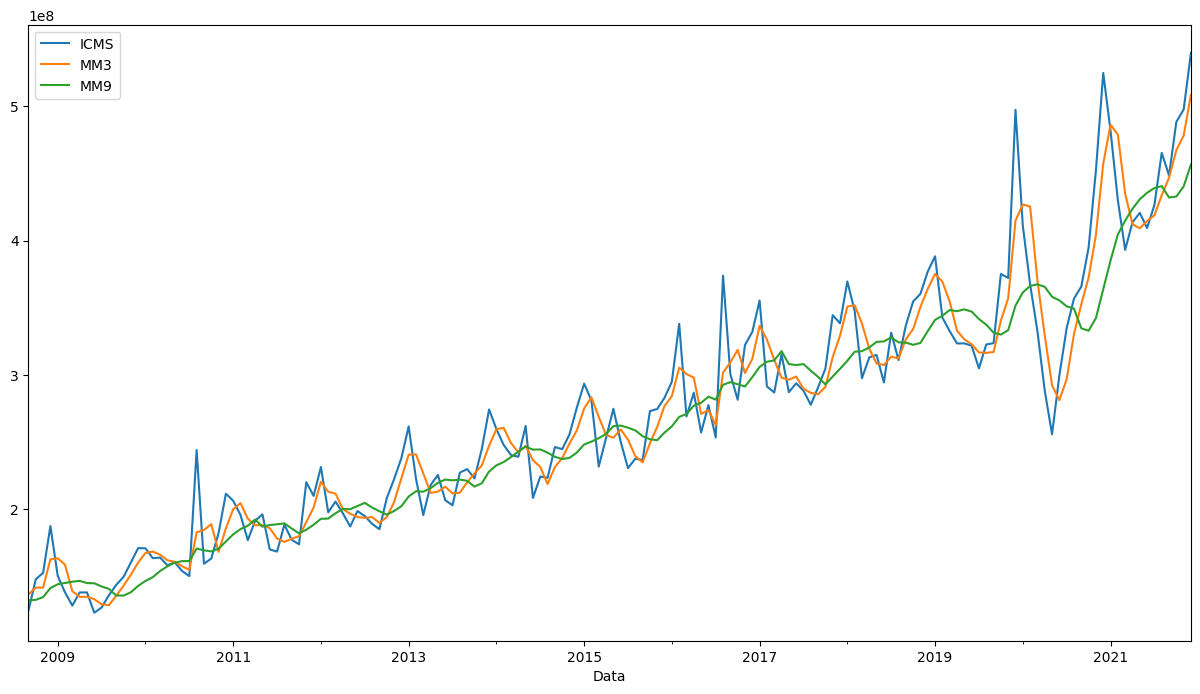

In [ ]:
icmsmm[['ICMS','MM3','MM9']].plot(figsize=(15, 8))

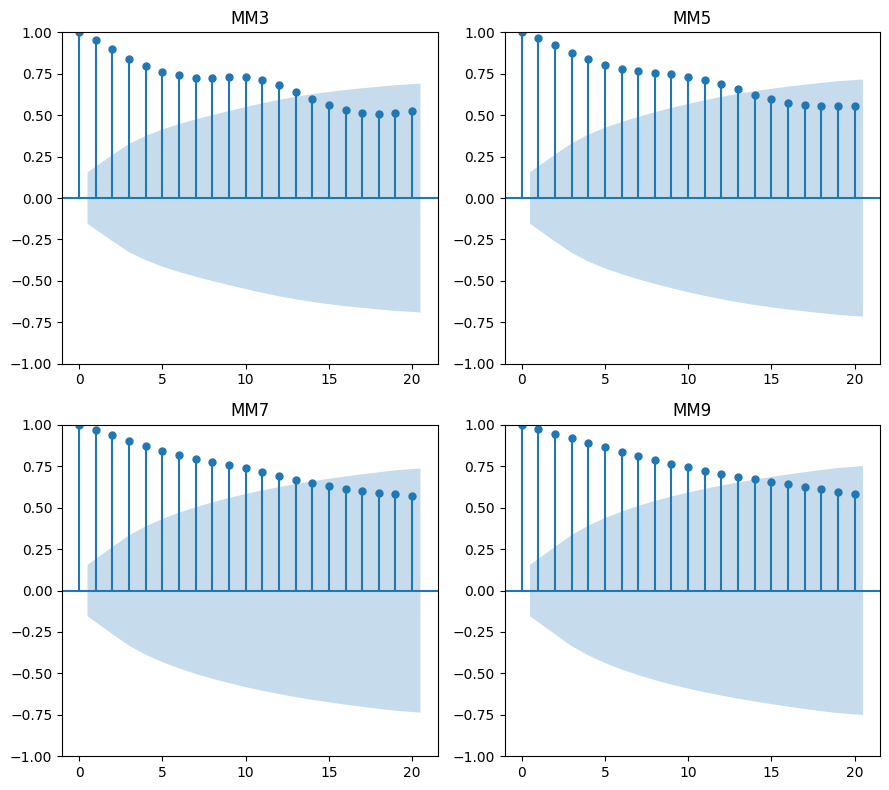

In [ ]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(9, 8))

for i, ax in zip(icmsmm.iloc[:, 2:].columns,(ax1, ax2, ax3, ax4)):
  # FAC
  plot_acf(icmsmm[i], lags=20, ax=ax)
  ax.set_title(i)
plt.tight_layout()
plt.show()

In [ ]:
icmsresid = pd.DataFrame(icmsresid)
icmsresid

,0
0,0.000000e+00
1,-4.777273e+06
2,-8.278297e+06
3,-7.508900e+06
4,-2.587648e+06
...,...
163,2.077864e+08
164,1.897007e+08
165,2.283268e+08
166,2.361237e+08


In [ ]:
# Criando os resíduos para cada média móvel
ms = [3,5,7,9]
for i in ms:
    residuos = icms.ICMS.values - icms['MM{}'.format(i)].values
    icmsresid['Residuos_MM{}'.format(i)] = residuos
icmsresid = icmsresid.rename(columns={0:'residuo_med'})
icmsresid

,residuo_med,Residuos_MM3,Residuos_MM5,Residuos_MM7,Residuos_MM9
0,0.000000e+00,NaN,NaN,NaN,NaN
1,-4.777273e+06,NaN,NaN,NaN,NaN
2,-8.278297e+06,-8.278297e+06,NaN,NaN,NaN
3,-7.508900e+06,-3.702438e+06,NaN,NaN,NaN
4,-2.587648e+06,2.271704e+06,-2.587648e+06,NaN,NaN
...,...,...,...,...,...
163,2.077864e+08,3.166301e+07,3.831741e+07,4.276694e+07,2.481923e+07
164,1.897007e+08,1.688544e+06,1.440534e+07,2.319524e+07,1.638866e+07
165,2.283268e+08,2.103030e+07,4.084836e+07,4.957167e+07,5.566057e+07
166,2.361237e+08,1.948286e+07,3.239455e+07,4.677033e+07,5.735453e+07


In [ ]:
icmsresid = icmsresid.dropna()
icmsresid

,residuo_med,Residuos_MM3,Residuos_MM5,Residuos_MM7,Residuos_MM9
8,-7.584219e+06,-1.210728e+07,-7.232629e+06,-5.560904e+06,-7.584219e+06
9,1.420955e+07,6.178753e+06,1.242328e+07,1.479395e+07,1.535177e+07
10,1.723740e+07,1.095860e+07,1.056047e+07,1.560135e+07,1.807719e+07
11,4.782587e+07,2.487471e+07,3.450723e+07,4.221315e+07,4.625656e+07
12,9.858858e+06,-1.311820e+07,-2.179429e+06,6.587271e+05,6.288872e+06
...,...,...,...,...,...
163,2.077864e+08,3.166301e+07,3.831741e+07,4.276694e+07,2.481923e+07
164,1.897007e+08,1.688544e+06,1.440534e+07,2.319524e+07,1.638866e+07
165,2.283268e+08,2.103030e+07,4.084836e+07,4.957167e+07,5.566057e+07
166,2.361237e+08,1.948286e+07,3.239455e+07,4.677033e+07,5.735453e+07


In [ ]:
boxpierceMM = pd.DataFrame(columns=['Média Móvel', 'Estatística de Teste', 'Valor-P'])

for coluna in icmsresid.columns:
    residuos = icmsresid[coluna]
    teste = sm.stats.acorr_ljungbox(residuos, lags=[12]).values
    m = sm.stats.acorr_ljungbox(icmsresid[coluna], boxpierce=True, lags=[12]).values
    boxpierceMM = boxpierceMM.append({'Média Móvel': coluna,
                                          'Estatística de Teste': m[0][2],
                                          'Valor-P': m[0][3]}, ignore_index=True)
boxpierceMM

,Média Móvel,Estatística de Teste,Valor-P
0,residuo_med,634.449935,4.628927e-128
1,Residuos_MM3,78.405308,8.306446e-12
2,Residuos_MM5,233.647004,3.479319e-43
3,Residuos_MM7,331.045947,1.388782e-63
4,Residuos_MM9,326.005435,1.599767e-62


**Nenhuma hipótese nula aceita**

### Suavização Exponencial

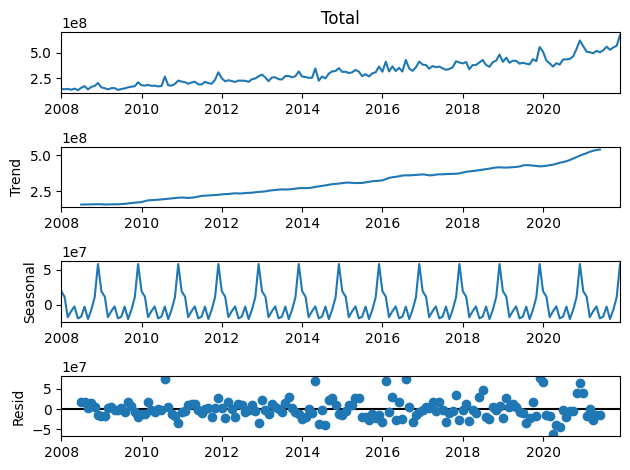

In [ ]:
# Decomposição da séries
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Total'])
results.plot();

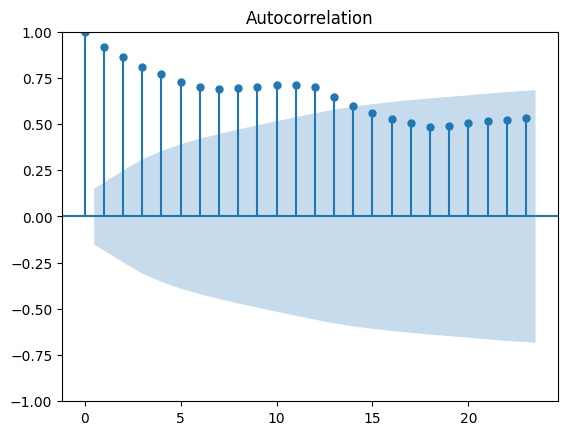

In [ ]:
plot_acf(icms.ICMS.values)
plt.show()

#### **Modelos sem tendência e sem sazonalidade (N-N)**

$$\hat{y}_{t+1} = y_t + \alpha(y_t - \hat{y}_t)$$

$$ 0 < \alpha < 1$$

$y_t$ é o valor no ponto e $\hat{y}_t$ é o valor ajustado no ponto, com $\alpha$ sendo a _constante de suavização_ e $(y_t - \hat{y}_t)$ o termo de erro associado à previsão anterior.

ou

$${a}_{t} = \alpha x_{t} + (1- \alpha)a_{t-1}$$

$$ 0 < \alpha < 1$$

Nível da séries temporal $a_t$ é definido como a média ponderada do valor atual da série temporal $x_t$ e do valor anterior do nível da série $a_{t-1}$.

**Despreza-se tendência e o efeito sazonal**

In [ ]:
icmss = pd.DataFrame(icms['ICMS'])
icmss

,ICMS
Data,
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2021-08-01,4.654184e+08
2021-09-01,4.484894e+08
2021-10-01,4.884993e+08


In [ ]:
# Suavização Exponencial - Resumo
mod_se = SimpleExpSmoothing(icmss.ICMS).fit(optimized=True)
mod_se.summary()

Dep. Variable:,ICMS,No. Observations:,168
Model:,SimpleExpSmoothing,SSE,149539793231870272.000
Optimized:,True,AIC,5786.959
Trend:,None,BIC,5793.207
Seasonal:,None,AICC,5787.204
Seasonal Periods:,None,Date:,"Sat, 03 Jun 2023"
Box-Cox:,False,Time:,15:12:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7993023,alpha,True
initial_level,1.435e+08,l.0,True


In [ ]:
# Suavização - Valores
icmss['SE'] = mod_se.fittedvalues
icmss

,ICMS,SE
Data,,
2008-01-01,1.435041e+08,1.435041e+08
2008-02-01,1.339496e+08,1.435041e+08
2008-03-01,1.263094e+08,1.358671e+08
2008-04-01,1.245758e+08,1.282276e+08
2008-05-01,1.288502e+08,1.253087e+08
...,...,...
2021-08-01,4.654184e+08,4.234352e+08
2021-09-01,4.484894e+08,4.569925e+08
2021-10-01,4.884993e+08,4.501959e+08


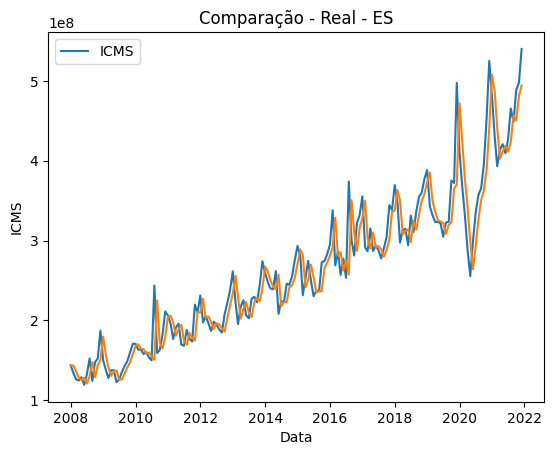

In [ ]:
seg = sns.lineplot(x=icmss.index,
             y=icmss.ICMS)
seg = sns.lineplot(x=icmss.index,
             y=icmss.SE)
seg.set_title('Comparação - Real - ES')
seg.legend(labels=['ICMS'])

In [ ]:
# separando o icms de novo
icms21 = pd.DataFrame(icms.ICMS.loc[icms.index <= '2022-12-01'])
icms21

,ICMS
Data,
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2021-08-01,4.654184e+08
2021-09-01,4.484894e+08
2021-10-01,4.884993e+08


In [ ]:
# Definindo variável de 99 a 2022 real
icms9922 = pd.DataFrame(df22.ICMS.loc[df22.index <= '2022-12-01'])
icms9922

,ICMS
Data,
1999-01-01,1.435041e+08
1999-02-01,1.339496e+08
1999-03-01,1.263094e+08
1999-04-01,1.245758e+08
1999-05-01,1.288502e+08
...,...
2022-08-01,4.350568e+08
2022-09-01,4.516591e+08
2022-10-01,4.914448e+08


In [ ]:
# Definindo variável de apenas 2022
icms22 = pd.DataFrame(df22.ICMS.loc[(df22.index >= '2022-01-01') & (df22.index <= '2022-12-01')])
icms22

,ICMS
Data,
2022-01-01,5.364485e+08
2022-02-01,4.901157e+08
2022-03-01,4.258561e+08
2022-04-01,5.374698e+08
2022-05-01,4.691268e+08
2022-06-01,5.204168e+08
2022-07-01,4.458553e+08
2022-08-01,4.350568e+08
2022-09-01,4.516591e+08


In [ ]:
# Suavização - previsão
pred_se = mod_se.forecast(12)
preddf_se = pd.concat([icms21.ICMS, pred_se])
preddf_se = pd.DataFrame(preddf_se)
preddf_se = preddf_se.rename(columns={0: 'Previsto - SE'})
preddf_se

,Previsto - SE
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2022-08-01,5.308805e+08
2022-09-01,5.308805e+08
2022-10-01,5.308805e+08
2022-11-01,5.308805e+08


In [ ]:
preddf_seprev = preddf_se.loc[preddf_se.index >= '2022-01-01']
preddf_seprev

,Previsto - SE
2022-01-01,5.308805e+08
2022-02-01,5.308805e+08
2022-03-01,5.308805e+08
2022-04-01,5.308805e+08
2022-05-01,5.308805e+08
2022-06-01,5.308805e+08
2022-07-01,5.308805e+08
2022-08-01,5.308805e+08
2022-09-01,5.308805e+08
2022-10-01,5.308805e+08


<Axes: xlabel='Data', ylabel='ICMS'>

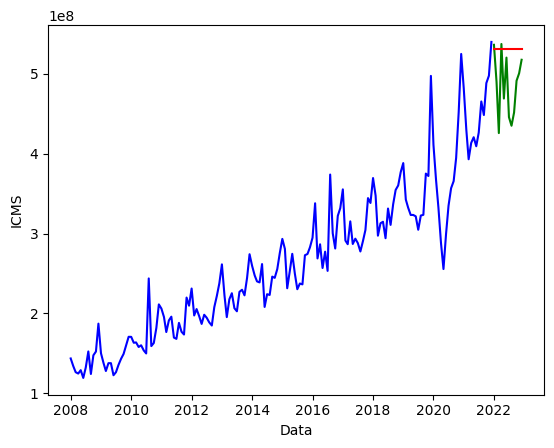

In [ ]:
# real 21
sns.lineplot(x=icms21.index,
             y=icms21.ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=preddf_seprev.index,
             y=preddf_seprev['Previsto - SE'],
             color = "red")

**<center>Métodos de avaliação de modelos:</center>**

Erro Percentual Médio Absoluto (MAPE):
$$MAPE = \frac{1}{n} \sum_{i=1}^{n} |\frac{y_t - \hat{y}_t}{y_t} * 100|$$

Erro Quadrático Médio (MSE):
$$MSE = \frac{1}{n} \sum_{i=1}^{n}(y_t - \hat{y}_t)^2$$

In [ ]:
# Comparação das previsões
# MAPEs - Erro Percentual Absoluto Médio
print('MAPE SE:', round(MAPE(icms22.ICMS, preddf_seprev['Previsto - SE'])*100,2),"%")
# MSEs - Erro Quadrático Médio
print('MSE SE:', round(MSE(icms22.ICMS, preddf_seprev['Previsto - SE']),2))

MAPE SE: 10.47 %
MSE SE: 3501081484191651.0


#### **Modelos com Tendência e Sazonalidade**

$$\hat{y}_t = (l_{t-1} + mb_{t-1})s_{t-s+m}$$
$$l_t = \alpha\left(\frac{y_t}{s_{t-s}}\right) + (1 - \alpha)(l_{t-1} + b_{t-1})$$
$$b_t = \beta(l_t - l_{t-1}) + (1 - \beta)b_{t-1}$$
$$s_t = \gamma\left(\frac{y_t}{l_t}\right) + (1 - \gamma)s_{t-s}$$

Onde:
- $\hat{y}_t$ é a previsão para o período $t$;
- $y_t$ é a previsão para o período $t$;
- $\alpha$ é o parâmetro de suavização do nível da série;
- $\beta$ é o parâmetro de suavização da tendência da série;
- $\gamma$ é o parâmetro de suavização da sazonalidade da série;
- $l_t$ é o nível estimado no período t.
- $b_t$ é a tendência estimada no período t.
- $s_t$ é o fator sazonal estimado no período t.
- $s$ é o comprimento da sazonalidade.

#### **Modelos com Tendência Aditiva e Sazonalidade Multiplicativa (A-M)**

In [ ]:
# Holt-Winters A-M - Resumo
mod_wh_am = ExponentialSmoothing(icmss.ICMS, seasonal_periods=12, trend='add', seasonal='mul').fit(optimized=1)
mod_wh_am.summary()

Dep. Variable:,ICMS,No. Observations:,168
Model:,ExponentialSmoothing,SSE,94421728963311968.000
Optimized:,True,AIC,5737.714
Trend:,Additive,BIC,5787.697
Seasonal:,Multiplicative,AICC,5742.305
Seasonal Periods:,12,Date:,"Sat, 03 Jun 2023"
Box-Cox:,False,Time:,15:12:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3585714,alpha,True
smoothing_trend,0.0210924,beta,True


In [ ]:
# Holt-Winters A-M - Valores
icmss['WH-AM'] = mod_wh_am.fittedvalues
icmss

,ICMS,SE,WH-AM
Data,,,
2008-01-01,1.435041e+08,1.435041e+08,1.543654e+08
2008-02-01,1.339496e+08,1.435041e+08,1.374322e+08
2008-03-01,1.263094e+08,1.358671e+08,1.311390e+08
2008-04-01,1.245758e+08,1.282276e+08,1.308895e+08
2008-05-01,1.288502e+08,1.253087e+08,1.273784e+08
...,...,...,...
2021-08-01,4.654184e+08,4.234352e+08,4.609136e+08
2021-09-01,4.484894e+08,4.569925e+08,4.423727e+08
2021-10-01,4.884993e+08,4.501959e+08,4.651614e+08


In [ ]:
# Holt-Winters - A-M - Previsão
pred_wh = mod_wh_am.forecast(12)
predval_wh_am = pd.concat([icmss['ICMS'], pred_wh])
predval_wh_am = pd.DataFrame(predval_wh_am)
predval_wh_am = predval_wh_am.rename(columns={0: 'Previsto - HWam'})
predval_wh_am

,Previsto - HWam
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2022-08-01,5.013645e+08
2022-09-01,4.795549e+08
2022-10-01,5.035814e+08
2022-11-01,5.361415e+08


In [ ]:
# df previsões WH AM
valprevisto_hw_am = predval_wh_am.loc[(predval_wh_am.index >= '2022-01-01')]
valprevisto_hw_am

,Previsto - HWam
2022-01-01,5.333122e+08
2022-02-01,4.884159e+08
2022-03-01,4.495923e+08
2022-04-01,4.610116e+08
2022-05-01,4.588801e+08
2022-06-01,4.491255e+08
2022-07-01,4.524818e+08
2022-08-01,5.013645e+08
2022-09-01,4.795549e+08
2022-10-01,5.035814e+08


In [ ]:
# Calculando os intervalos de confiança
valprevisto_hw_am['Intervalo Inferior'] = valprevisto_hw_am['Previsto - HWam'] - 1.96 * valprevisto_hw_am['Previsto - HWam'].sem()
valprevisto_hw_am['Intervalo Superior'] = valprevisto_hw_am['Previsto - HWam'] + 1.96 * valprevisto_hw_am['Previsto - HWam'].sem()
valprevisto_hw_am

,Previsto - HWam,Intervalo Inferior,Intervalo Superior
2022-01-01,5.333122e+08,5.086096e+08,5.580148e+08
2022-02-01,4.884159e+08,4.637133e+08,5.131185e+08
2022-03-01,4.495923e+08,4.248897e+08,4.742948e+08
2022-04-01,4.610116e+08,4.363090e+08,4.857141e+08
2022-05-01,4.588801e+08,4.341775e+08,4.835827e+08
2022-06-01,4.491255e+08,4.244229e+08,4.738281e+08
2022-07-01,4.524818e+08,4.277792e+08,4.771844e+08
2022-08-01,5.013645e+08,4.766619e+08,5.260671e+08
2022-09-01,4.795549e+08,4.548523e+08,5.042575e+08
2022-10-01,5.035814e+08,4.788789e+08,5.282840e+08


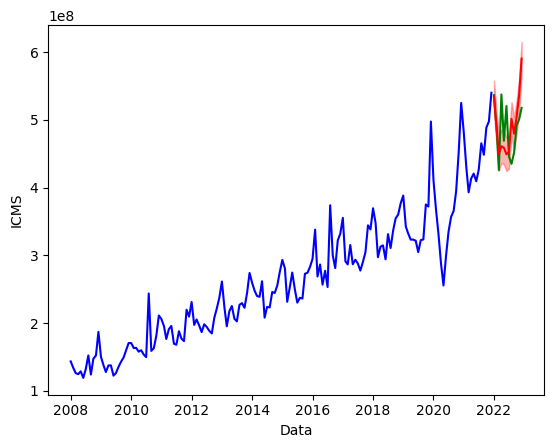

In [ ]:
# real 21
sns.lineplot(x=icms21.index,
             y=icms21.ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=valprevisto_hw_am.index,
             y=valprevisto_hw_am['Previsto - HWam'],
             color = "red")
# Plotar o intervalo de confiança
plt.fill_between(valprevisto_hw_am.index, valprevisto_hw_am['Intervalo Inferior'], valprevisto_hw_am['Intervalo Superior'], alpha=0.3, color='red')


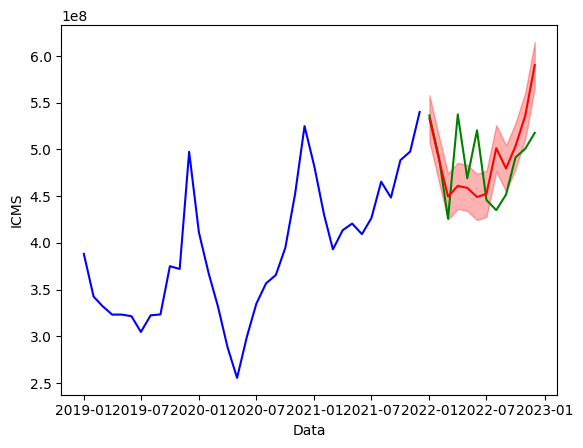

In [ ]:
# real 21
sns.lineplot(x=icms21.loc[icms21.index >= '2019-01-01'].index,
             y=icms21.loc[icms21.index >= '2019-01-01'].ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=valprevisto_hw_am.index,
             y=valprevisto_hw_am['Previsto - HWam'],
             color = "red")
# Plotar o intervalo de confiança
plt.fill_between(valprevisto_hw_am.index, valprevisto_hw_am['Intervalo Inferior'], valprevisto_hw_am['Intervalo Superior'], alpha=0.3, color='red')

In [ ]:
# Comparação das previsões
# MAPEs - Erro Percentual Absoluto Médio
print('MAPE SE:', round(MAPE(icms22.ICMS, preddf_seprev['Previsto - SE'])*100,2),"%")
print('MAPE HW-AM:', round(MAPE(icms22.ICMS, valprevisto_hw_am['Previsto - HWam'])*100,2),"%")
# MSEs - Erro Quadrático Médio
print('MSE SE:', round(MSE(icms22.ICMS, preddf_seprev['Previsto - SE']),2))
print('MSE HW:', round(MSE(icms22.ICMS, valprevisto_hw_am['Previsto - HWam']),2))

MAPE SE: 10.47 %
MAPE HW-AM: 6.92 %
MSE SE: 3501081484191651.0
MSE HW: 1958389188759213.0


#### **Modelos com Tendência Aditiva e Sazonalidade Aditiva (A-A)**

In [ ]:
# Holt-Winters A-A - Resumo
mod_wh_aa = ExponentialSmoothing(icmss.ICMS, seasonal_periods=12, trend='add', seasonal='add').fit(optimized=1)
mod_wh_aa.summary()

Dep. Variable:,ICMS,No. Observations:,168
Model:,ExponentialSmoothing,SSE,100455202741835632.000
Optimized:,True,AIC,5748.120
Trend:,Additive,BIC,5798.104
Seasonal:,Additive,AICC,5752.711
Seasonal Periods:,12,Date:,"Sat, 03 Jun 2023"
Box-Cox:,False,Time:,15:13:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3232143,alpha,True
smoothing_trend,0.0202009,beta,True


In [ ]:
# Holt-Winters A-A - Valores
icmss['WH-AA'] = mod_wh_aa.fittedvalues
icmss

,ICMS,SE,WH-AM,WH-AA
Data,,,,
2008-01-01,1.435041e+08,1.435041e+08,1.543654e+08,1.583260e+08
2008-02-01,1.339496e+08,1.435041e+08,1.374322e+08,1.366412e+08
2008-03-01,1.263094e+08,1.358671e+08,1.311390e+08,1.298415e+08
2008-04-01,1.245758e+08,1.282276e+08,1.308895e+08,1.300079e+08
2008-05-01,1.288502e+08,1.253087e+08,1.273784e+08,1.262505e+08
...,...,...,...,...
2021-08-01,4.654184e+08,4.234352e+08,4.609136e+08,4.447891e+08
2021-09-01,4.484894e+08,4.569925e+08,4.423727e+08,4.518095e+08
2021-10-01,4.884993e+08,4.501959e+08,4.651614e+08,4.695771e+08


In [ ]:
# Holt-Winters - A-A - Previsão
pred_wh_aa = mod_wh_aa.forecast(12)
predval_wh_aa = pd.concat([icmss['ICMS'], pred_wh_aa])
predval_wh_aa = pd.DataFrame(predval_wh_aa)
predval_wh_aa = predval_wh_aa.rename(columns={0: 'Previsto - HWaa'})
predval_wh_aa

,Previsto - HWaa
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2022-08-01,4.967434e+08
2022-09-01,4.923092e+08
2022-10-01,5.158991e+08
2022-11-01,5.327394e+08


In [ ]:
# df previsões WH AA
valprevisto_hw_aa = predval_wh_aa.loc[(predval_wh_aa.index >= '2022-01-01')]
valprevisto_hw_aa

,Previsto - HWaa
2022-01-01,5.107598e+08
2022-02-01,4.758763e+08
2022-03-01,4.497091e+08
2022-04-01,4.574023e+08
2022-05-01,4.573437e+08
2022-06-01,4.625652e+08
2022-07-01,4.736135e+08
2022-08-01,4.967434e+08
2022-09-01,4.923092e+08
2022-10-01,5.158991e+08


In [ ]:
# Calculando os intervalos de confiança
valprevisto_hw_aa['Intervalo Inferior'] = valprevisto_hw_aa['Previsto - HWaa'] - 1.96 * valprevisto_hw_aa['Previsto - HWaa'].sem()
valprevisto_hw_aa['Intervalo Superior'] = valprevisto_hw_aa['Previsto - HWaa'] + 1.96 * valprevisto_hw_aa['Previsto - HWaa'].sem()
valprevisto_hw_aa

,Previsto - HWaa,Intervalo Inferior,Intervalo Superior
2022-01-01,5.107598e+08,4.902446e+08,5.312751e+08
2022-02-01,4.758763e+08,4.553610e+08,4.963916e+08
2022-03-01,4.497091e+08,4.291938e+08,4.702244e+08
2022-04-01,4.574023e+08,4.368870e+08,4.779176e+08
2022-05-01,4.573437e+08,4.368284e+08,4.778590e+08
2022-06-01,4.625652e+08,4.420499e+08,4.830805e+08
2022-07-01,4.736135e+08,4.530982e+08,4.941288e+08
2022-08-01,4.967434e+08,4.762281e+08,5.172587e+08
2022-09-01,4.923092e+08,4.717939e+08,5.128245e+08
2022-10-01,5.158991e+08,4.953838e+08,5.364144e+08


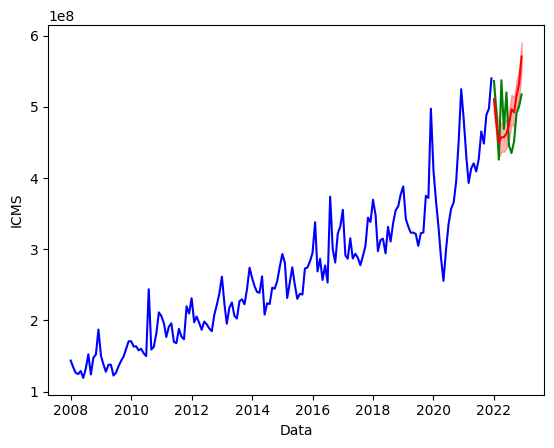

In [ ]:
# real 21
sns.lineplot(x=icms21.index,
             y=icms21.ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=valprevisto_hw_aa.index,
             y=valprevisto_hw_aa['Previsto - HWaa'],
             color = "red")
# Plotar o intervalo de confiança
plt.fill_between(valprevisto_hw_aa.index, valprevisto_hw_aa['Intervalo Inferior'], valprevisto_hw_aa['Intervalo Superior'], alpha=0.3, color='red')


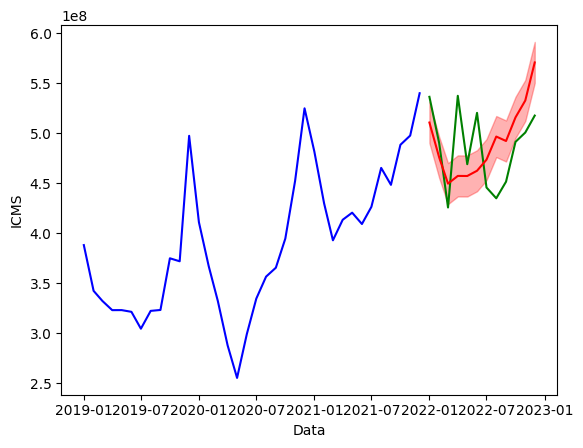

In [ ]:
# real 21
sns.lineplot(x=icms21.loc[icms21.index >= '2019-01-01'].index,
             y=icms21.loc[icms21.index >= '2019-01-01'].ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=valprevisto_hw_aa.index,
             y=valprevisto_hw_aa['Previsto - HWaa'],
             color = "red")
# Plotar o intervalo de confiança
plt.fill_between(valprevisto_hw_aa.index, valprevisto_hw_aa['Intervalo Inferior'], valprevisto_hw_aa['Intervalo Superior'], alpha=0.3, color='red')


In [ ]:
# Comparação das previsões
# MAPEs - Erro Percentual Absoluto Médio
print('MAPE SE:', round(MAPE(icms22.ICMS, preddf_seprev['Previsto - SE'])*100,2),"%")
print('MAPE HW-AM:', round(MAPE(icms22.ICMS, valprevisto_hw_am['Previsto - HWam'])*100,2),"%")
print('MAPE HW-AA:', round(MAPE(icms22.ICMS, valprevisto_hw_aa['Previsto - HWaa'])*100,2),"%")
# MSEs - Erro Quadrático Médio
print('MSE SE:', round(MSE(icms22.ICMS, preddf_seprev['Previsto - SE']),2))
print('MSE HW-AM:', round(MSE(icms22.ICMS, valprevisto_hw_am['Previsto - HWam']),2))
print('MSE HW-AA:', round(MSE(icms22.ICMS, valprevisto_hw_aa['Previsto - HWaa']),2))

MAPE SE: 10.47 %
MAPE HW-AM: 6.92 %
MAPE HW-AA: 7.74 %
MSE SE: 3501081484191651.0
MSE HW-AM: 1958389188759213.0
MSE HW-AA: 1833088611962170.2


**Modelos com Tendência Amortecida Aditiva e Sazonalidade Aditiva (M-M)**

In [ ]:
# Holt-Winters M-M - Resumo
mod_wh_mm = ExponentialSmoothing(icmss.ICMS, seasonal_periods=12, trend='mul', seasonal='mul').fit(optimized=1)
mod_wh_mm.summary()

Dep. Variable:,ICMS,No. Observations:,168
Model:,ExponentialSmoothing,SSE,94344579095133248.000
Optimized:,True,AIC,5737.577
Trend:,Multiplicative,BIC,5787.560
Seasonal:,Multiplicative,AICC,5742.167
Seasonal Periods:,12,Date:,"Sat, 03 Jun 2023"
Box-Cox:,False,Time:,15:13:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3585714,alpha,True
smoothing_trend,0.0210924,beta,True


In [ ]:
# Holt-Winters M-M - Valores
icmss['WH-MM'] = mod_wh_mm.fittedvalues
icmss

,ICMS,SE,WH-AM,WH-AA,WH-MM
Data,,,,,
2008-01-01,1.435041e+08,1.435041e+08,1.543654e+08,1.583260e+08,1.543654e+08
2008-02-01,1.339496e+08,1.435041e+08,1.374322e+08,1.366412e+08,1.374280e+08
2008-03-01,1.263094e+08,1.358671e+08,1.311390e+08,1.298415e+08,1.311313e+08
2008-04-01,1.245758e+08,1.282276e+08,1.308895e+08,1.300079e+08,1.308782e+08
2008-05-01,1.288502e+08,1.253087e+08,1.273784e+08,1.262505e+08,1.273641e+08
...,...,...,...,...,...
2021-08-01,4.654184e+08,4.234352e+08,4.609136e+08,4.447891e+08,4.640274e+08
2021-09-01,4.484894e+08,4.569925e+08,4.423727e+08,4.518095e+08,4.452501e+08
2021-10-01,4.884993e+08,4.501959e+08,4.651614e+08,4.695771e+08,4.682631e+08


In [ ]:
# Holt-Winters - M-M - Previsão
pred_wh_mm = mod_wh_mm.forecast(12)
valprevisto_hw_mm = pd.concat([icmss['ICMS'], pred_wh_mm])
valprevisto_hw_mm = pd.DataFrame(valprevisto_hw_mm)
valprevisto_hw_mm = valprevisto_hw_mm.rename(columns={0: 'Previsto - HWmm'})
valprevisto_hw_mm

,Previsto - HWmm
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2022-08-01,5.142152e+08
2022-09-01,4.930734e+08
2022-10-01,5.192113e+08
2022-11-01,5.543883e+08


In [ ]:
# Calculando os intervalos de confiança
valprevisto_hw_mm['Intervalo Inferior'] = valprevisto_hw_mm['Previsto - HWmm'] - 1.96 * valprevisto_hw_mm['Previsto - HWmm'].sem()
valprevisto_hw_mm['Intervalo Superior'] = valprevisto_hw_mm['Previsto - HWmm'] + 1.96 * valprevisto_hw_mm['Previsto - HWmm'].sem()
valprevisto_hw_mm

,Previsto - HWmm,Intervalo Inferior,Intervalo Superior
2008-01-01,1.435041e+08,1.273999e+08,1.596083e+08
2008-02-01,1.339496e+08,1.178454e+08,1.500538e+08
2008-03-01,1.263094e+08,1.102052e+08,1.424136e+08
2008-04-01,1.245758e+08,1.084716e+08,1.406800e+08
2008-05-01,1.288502e+08,1.127460e+08,1.449544e+08
...,...,...,...
2022-08-01,5.142152e+08,4.981110e+08,5.303194e+08
2022-09-01,4.930734e+08,4.769692e+08,5.091776e+08
2022-10-01,5.192113e+08,5.031071e+08,5.353155e+08
2022-11-01,5.543883e+08,5.382841e+08,5.704925e+08


In [ ]:
# df previsões WH MM
valprevisto_hw_mm = valprevisto_hw_mm.loc[(valprevisto_hw_mm.index >= '2022-01-01')]
valprevisto_hw_mm

,Previsto - HWmm,Intervalo Inferior,Intervalo Superior
2022-01-01,5.370088e+08,5.209046e+08,5.531130e+08
2022-02-01,4.930181e+08,4.769139e+08,5.091223e+08
2022-03-01,4.549842e+08,4.388800e+08,4.710884e+08
2022-04-01,4.677444e+08,4.516402e+08,4.838486e+08
2022-05-01,4.668160e+08,4.507118e+08,4.829202e+08
2022-06-01,4.580316e+08,4.419274e+08,4.741358e+08
2022-07-01,4.626898e+08,4.465856e+08,4.787940e+08
2022-08-01,5.142152e+08,4.981110e+08,5.303194e+08
2022-09-01,4.930734e+08,4.769692e+08,5.091776e+08
2022-10-01,5.192113e+08,5.031071e+08,5.353155e+08


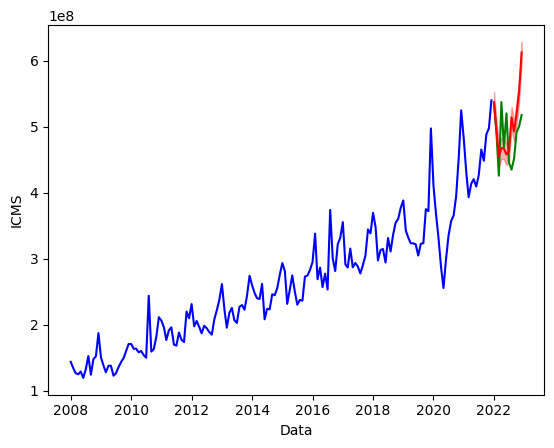

In [ ]:
# real 21
sns.lineplot(x=icms21.index,
             y=icms21.ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=valprevisto_hw_mm.index,
             y=valprevisto_hw_mm['Previsto - HWmm'],
             color = "red")
# Plotar o intervalo de confiança
plt.fill_between(valprevisto_hw_mm.index, valprevisto_hw_mm['Intervalo Inferior'], valprevisto_hw_mm['Intervalo Superior'], alpha=0.3, color='red')


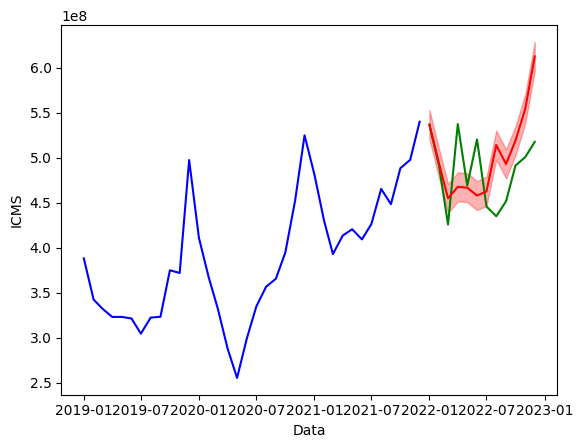

In [ ]:
# real 21
sns.lineplot(x=icms21.loc[icms21.index >= '2019-01-01'].index,
             y=icms21.loc[icms21.index >= '2019-01-01'].ICMS,
             color = 'blue')
# real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green")
# previsto 22
sns.lineplot(x=valprevisto_hw_mm.index,
             y=valprevisto_hw_mm['Previsto - HWmm'],
             color = "red")
# Plotar o intervalo de confiança
plt.fill_between(valprevisto_hw_mm.index, valprevisto_hw_mm['Intervalo Inferior'], valprevisto_hw_mm['Intervalo Superior'], alpha=0.3, color='red')

In [ ]:
# Comparação das previsões
# MAPEs - Erro Percentual Absoluto Médio
print('MAPE SE:', round(MAPE(icms22.ICMS, preddf_seprev['Previsto - SE'])*100,2),"%")
print('MAPE HW-AM:', round(MAPE(icms22.ICMS, valprevisto_hw_am['Previsto - HWam'])*100,2),"%")
print('MAPE HW-AA:', round(MAPE(icms22.ICMS, valprevisto_hw_aa['Previsto - HWaa'])*100,2),"%")
print('MAPE HW-MM:', round(MAPE(icms22.ICMS, valprevisto_hw_mm['Previsto - HWmm'])*100,2),"%")
# MSEs - Erro Quadrático Médio
print('MSE SE:', round(MSE(icms22.ICMS, preddf_seprev['Previsto - SE']),2))
print('MSE HW-AM:', round(MSE(icms22.ICMS, valprevisto_hw_am['Previsto - HWam']),2))
print('MSE HW-AA:', round(MSE(icms22.ICMS, valprevisto_hw_aa['Previsto - HWaa']),2))
print('MSE HW-MM:', round(MSE(icms22.ICMS, valprevisto_hw_mm['Previsto - HWmm']),2))

MAPE SE: 10.47 %
MAPE HW-AM: 6.92 %
MAPE HW-AA: 7.74 %
MAPE HW-MM: 8.23 %
MSE SE: 3501081484191651.0
MSE HW-AM: 1958389188759213.0
MSE HW-AA: 1833088611962170.2
MSE HW-MM: 2544068295354112.0


**Melhor modelo, com base no MAPE, é o Holt-Winter com Tendência Aditiva e Sasonalidade Multiplicativa**

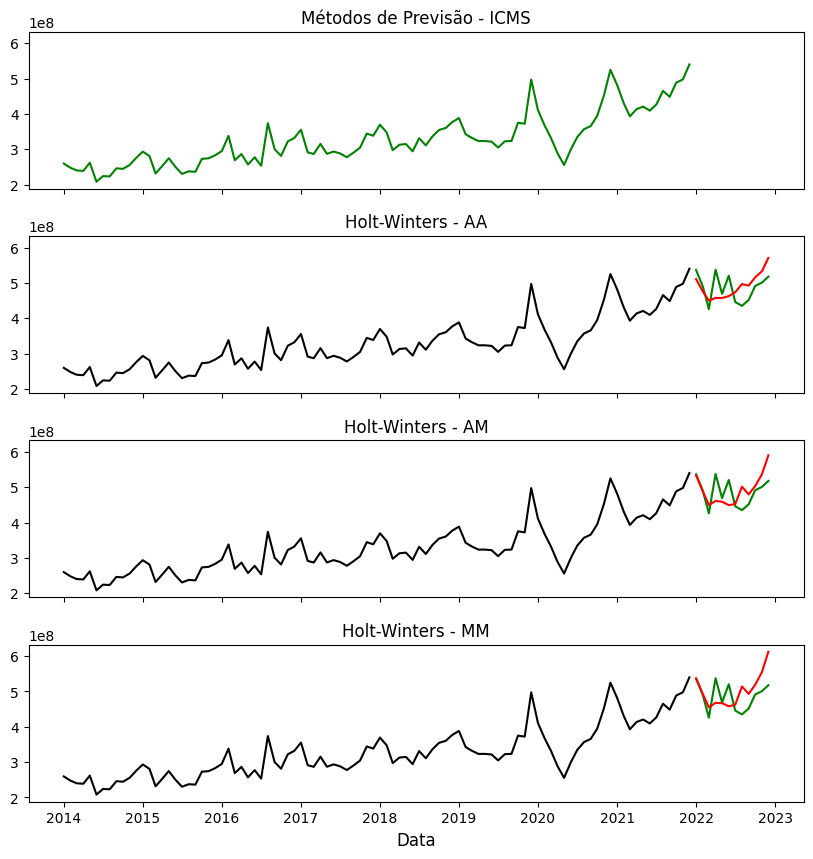

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharey=True, 
                                         sharex=True, figsize=(10, 10))
# ax1
# real 21
sns.lineplot(x=icms21.loc[icms21.index >= '2014-01-01'].index,
             y=icms21.loc[icms21.index >= '2014-01-01'].ICMS,
             color='green',
            ax=ax1)
# ax2 - AA
# base
sns.lineplot(x=icms21.loc[icms21.index >= '2014-01-01'].index,
             y=icms21.loc[icms21.index >= '2014-01-01'].ICMS,
             color='black',
            ax=ax2)
#real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green",
             ax=ax2)
# previsto 22
sns.lineplot(x=valprevisto_hw_aa.index,
             y=valprevisto_hw_aa['Previsto - HWaa'],
             color = "red",
             ax=ax2)
# ax2 - AM
# base
sns.lineplot(x=icms21.loc[icms21.index >= '2014-01-01'].index,
             y=icms21.loc[icms21.index >= '2014-01-01'].ICMS,
             color='black',
            ax=ax3)
#real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green",
             ax=ax3)
# previsto 22
sns.lineplot(x=valprevisto_hw_am.index,
             y=valprevisto_hw_am['Previsto - HWam'],
             color = "red",
             ax=ax3)
# ax2 - MM
# base
sns.lineplot(x=icms21.loc[icms21.index >= '2014-01-01'].index,
             y=icms21.loc[icms21.index >= '2014-01-01'].ICMS,
             color='black',
            ax=ax4)
#real 22
sns.lineplot(x=icms22.index,
             y=icms22.ICMS,
             color = "green",
             ax=ax4)
# previsto 22
sns.lineplot(x=valprevisto_hw_mm.index,
             y=valprevisto_hw_mm['Previsto - HWmm'],
             color = "red",
             ax=ax4)
# Ajustar os títulos dos eixos e o espaçamento
plt.subplots_adjust(hspace=0.3)
ax1.set_title('Métodos de Previsão - ICMS')
ax2.set_title('Holt-Winters - AA', fontsize=12)
ax3.set_title('Holt-Winters - AM', fontsize=12)
ax4.set_title('Holt-Winters - MM', fontsize=12)
for i in (ax1,ax2,ax3,ax4):
  i.set_xlabel('Data', fontsize=12)
  i.set_ylabel('', fontsize=12)
plt.show()

### Metodologia Box&Jenkins

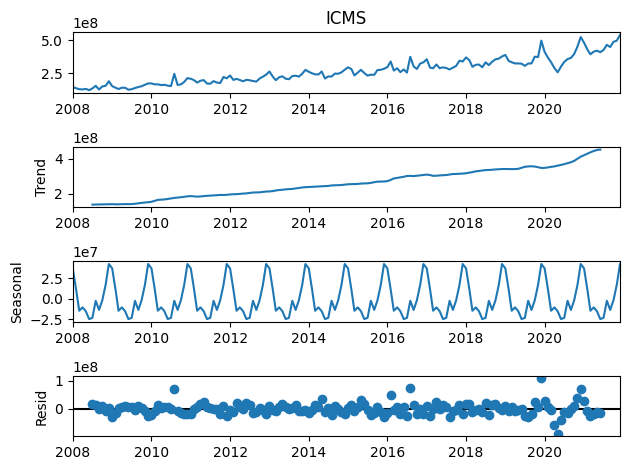

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(icms.ICMS);
results.plot();  

In [ ]:
# Teste de estacionariedade - Raiz unitária - Dick-Fuller Aumentado
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(icms.ICMS)
print('Adfuller Valor-p: ', adftest[1])

Adfuller Valor-p:  0.9990590455053716


H0: Raiz Unitária \
H1: Não estacionária \
**Rejeita-se a hipótese nula**

#### Dividindo os treinos e testes

In [ ]:
treino=icms21
treino

,ICMS
Data,
2008-01-01,1.435041e+08
2008-02-01,1.339496e+08
2008-03-01,1.263094e+08
2008-04-01,1.245758e+08
2008-05-01,1.288502e+08
...,...
2021-08-01,4.654184e+08
2021-09-01,4.484894e+08
2021-10-01,4.884993e+08


In [ ]:
teste=icms22
teste

,ICMS
Data,
2022-01-01,5.364485e+08
2022-02-01,4.901157e+08
2022-03-01,4.258561e+08
2022-04-01,5.374698e+08
2022-05-01,4.691268e+08
2022-06-01,5.204168e+08
2022-07-01,4.458553e+08
2022-08-01,4.350568e+08
2022-09-01,4.516591e+08


In [ ]:
treino = icms.ICMS[:126]

AR: Autoregressivo: Correlação com valores passados: AR(p) \
MA: Médias Móveis: Corelação com erros passados: MA(q) \
I: Integrado (estacionarizar): Quantas vezes vai ser diferenciado do dados originais: I(d)


#### Obtendo o melhor parâmetro

In [ ]:
import itertools

In [ ]:
p = range(0,12)
d = range(0,2)
q = range(0,12)

In [ ]:
pdqcomp = list(itertools.product(p,d,q))

In [ ]:
pdqcomp

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 0, 10),
 (0, 0, 11),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 1, 10),
 (0, 1, 11),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 0, 8),
 (1, 0, 9),
 (1, 0, 10),
 (1, 0, 11),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9),
 (1, 1, 10),
 (1, 1, 11),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 6),
 (2, 0, 7),
 (2, 0, 8),
 (2, 0, 9),
 (2, 0, 10),
 (2, 0, 11),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 1, 8),
 (2, 1, 9),
 (2, 1, 10),
 (2, 1, 11),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 0, 5),
 (3, 0, 6),
 (3, 0, 7),
 (3, 0, 8),
 (3, 0, 9),
 (3,

In [ ]:
rmse=[]
order1=[]

In [ ]:
for pdq in pdqcomp:
  try:
      model=ARIMA(treino,order=pdq).fit()
      pred=model.predict(start=(len(icms.ICMS)*0,25), end=(len(icms.ICMS)*0,75))
      error = np.sqrt(MSE(teste,pred))
      order1.append(pdq)
      rmse.append(error)
  except:
      continue

In [ ]:
result = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])
result

,RMSE


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
modelo = ARIMA(icmsteste.Valor, order=(5,5,1), freq='M')
modelo_fit = modelo.fit()
print(modelo_fit.summary())